## Chapter 5: Excercise 5.5

Write a program to classify the `phoneme` data using a quadratic discriminal analysis (section 4.3). Since there are many correlated features, you should filter them using a smooth basis of natural cubic splines (Section 5.2.3). Decide beforehand on a series of five different choices for the number and position of the knots, and use tenflod cross-validation to make the final selection. The `phoneme` data are avairable from the book website `www-stat.stanford.edu/ElemStatLearn`.

Beforehand the five way to assign the knots are:

  1. 12 knots equally spaced between 1 and 256 (not inclusive).
  2. 9 knots placed on quantiles $(0.1, \dots, 0.9)$
  3. 20 knots equally for quintiles. $(0.5, 0.1, \dots, 0.95)$
  4. 10 knots equally spaced for frequencies below 128 and 5 knots equally spaced after
  5. Two boundary knots at 0.05 and 0.95 quantiles and 20 knots equally spaced in between

In [622]:
import pandas as pd
import functions_section_5 as fs5
import sklearn.metrics as skm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from importlib import reload
from sklearn.preprocessing import LabelEncoder, FunctionTransformer

In [526]:
phoneme_data = pd.read_csv(
    'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/phoneme.data',
    index_col=0
)

phoneme_data['set'] = phoneme_data.speaker.str.split('.', expand=True)[0]
df_train = phoneme_data.query('set == "train"')
df_test = phoneme_data.query('set == "test"')
phoneme_data = phoneme_data.drop(columns=['set'])

X_train, y_train = (
    train.iloc[:, :p].to_numpy(),
    train['g'].to_numpy()
)

X_test, y_test =(
    test.iloc[:, :p].to_numpy(),
    test.loc[:, 'g'].to_numpy()
)

## QDA implementation


The quadradict discriminat function is defined as (eq (4.12), page 110):

$$
\delta_k(x) = -\frac{1}{2} \text{log} \left|\Sigma_k \right| - \frac{1}{2} \left(x - \mu_k\right)^{T} \Sigma^{-1} \left(x - \mu_k \right) + \text{log}\pi_k
$$

And $G(x) = \text{argmax}_{k} \delta_{k}(X)$

In [623]:
qda_classifer_raw = QuadraticDiscriminantAnalysis()
qda_classifer_raw.fit(X_train, y_train)
y_pred_train_raw = qda_classifer_raw.predict(X_train)
y_pred_test_raw = qda_classifer_raw.predict(X_test)

print('Train Accuracy: {:.2f}'.format(
    skm.accuracy_score(y_train, y_pred_train
)))

print('Test Accuracy: {:.2f}'.format(
    skm.accuracy_score(y_test, y_pred_test
)))

Train Accuracy: 1.00
Test Accuracy: 0.84


There are strong evidence of overfitting as the accuracy of train is 100% and test is only 84%. This is using only a simple stratified `train_test_split`

## Generating Knots and Natural Cubic Base

In [670]:
frequencies = np.arange(1, 257)
frequencies_below = np.arange(1, 129, 1)

percentile_5 = np.quantile(frequencies, 0.05)
percentile_95 = np.quantile(frequencies, 0.95)

knots = [
    np.linspace(1, 256, 13, endpoint=False)[1:],
    np.quantile(frequencies, np.arange(0.1, 1, 0.1)),
    np.quantile(frequencies, np.arange(0.05, 1, 0.05)),
    np.concatenate([
        np.linspace(1, 128, 11)[1:],
        np.linspace(128, 256, 5, endpoint=False)[1:]
    ]),
    np.concatenate([
        [percentile_5],
        np.arange(percentile_5, percentile_95, 20)[1:],
        [percentile_95],
    ])
]

num_knots = [k.shape[0] for k in knots]

knots = [x for _,x in sorted(zip(num_knots, knots))]
num_knots.sort()

def filter_strategy(knot_strategy):
    cubic_spline = fs5.cubic_spline_base(knot_strategy)
    frequencies = np.arange(1, 257)
    H = cubic_spline.generate_basis_matrix(frequencies)
    
    def filter_X(X):
        return X @ H
    
    return filter_X

filters = [filter_strategy(knot_strategy) for knot_strategy in knots]

## Training the Model

In [671]:
estimators = [
    ('filter', FunctionTransformer()),
    ('qda',  QuadraticDiscriminantAnalysis())
]

param_grid = {'filter__func':filters}
pipe = Pipeline(estimators)

grid_search = GridSearchCV(
    pipe,
    param_grid,
    scoring='accuracy',
    cv=10,
    return_train_score=True,
    refit=True
)

grid_search.fit(X_train, y_train);

## Plotting Results

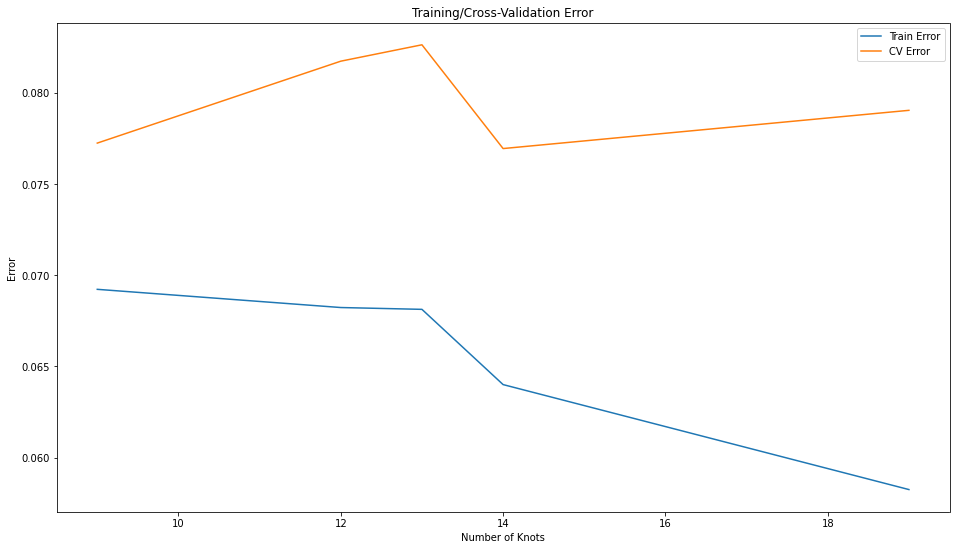

In [680]:
# Initialise figure
num_knots = [k.shape[0] for k in knots]
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(num_knots, 1-grid_search.cv_results_['mean_train_score'], label='Train Error')
ax.plot(num_knots, 1-grid_search.cv_results_['mean_test_score'], label='CV Error')

# Fig parameters
ax.set_title('Training/Cross-Validation Error')
ax.set_xlabel('Number of Knots')
ax.set_ylabel('Error')

ax.legend();

In [689]:
y_pred_train_best_model = grid_search.predict(X_train)
y_pred_test_best_model = grid_search.predict(X_test)

print('Regularized Model:')
print('Train Accuracy: {:.2f}'.format(
    skm.accuracy_score(y_train, y_pred_train_best_model)
))

print('Test Accuracy: {:.2f}'.format(
    skm.accuracy_score(y_test, y_pred_test_best_model)
))

print('\nRaw Model:')
print('Train Accuracy: {:.2f}'.format(
    skm.accuracy_score(y_train, y_pred_train
)))

print('Test Accuracy: {:.2f}'.format(
    skm.accuracy_score(y_test, y_pred_test
)))

Regularized Model:
Train Accuracy: 0.94
Test Accuracy: 0.93

Raw Model:
Train Accuracy: 1.00
Test Accuracy: 0.84


---
It is clear regularized  model is not overfitting the data